In [15]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

## Module 3 Homework (2025 Cohort)

In this homework, we're going to work with categorical variables, first ML models (Decision Trees), and hyperparameter tuning.

Please use the [Colab Module 3](https://github.com/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/03-modeling/%5B2025%5D_Module_3_Colab_Time_Series_Modeling.ipynb) for all tasks to ensure you have the same dataframe used for the Modeling part, as covered during the lecture. 

**HINT**: If you want to avoid data truncation in GitHub's UI, try either of the following options:
* Open the notebook in [Colab, using the GitHub link to the notebook](https://colab.research.google.com/github/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/03-modeling/%5B2025%5D_Module_3_Colab_Time_Series_Modeling.ipynb).
* Clone the repository to a local folder and open the notebook in Jupyter Notebook.
---
### Question 1: Dummies for Month and Week-of-Month

**What is the ABSOLUTE CORRELATION VALUE of the most correlated dummy variable <month>_w<week_of_month> with the binary outcome `is_positive_growth_30d_future`?**

From the correlation analysis and modeling, you may have observed that October and November are potentially important seasonal months. In this task, you'll go further by generating dummy variables for both the **Month** and **Week-of-Month** (starting from 1). For example, the first week of October should be coded as: `'October_w1'`.

Once you've generated these new variables, identify the one with the **highest absolute correlation** with `is_positive_growth_30d_future`, and round the result to **three decimal places**.


#### Suggested Steps

1. Use [this StackOverflow reference](https://stackoverflow.com/questions/25249033/week-of-a-month-pandas) to compute the week of the month using the following formula:
  ```python
  (d.day - 1) // 7 + 1
  ```
2. Create a new string variable that combines the month name and week of the month.
Example: 'October_w1', 'November_w2', etc.

3. Add the new variable (e.g., `month_wom`) to your set of **categorical features**.

   Your updated categorical feature list should include:
   - `'Month'`
   - `'Weekday'`
   - `'Ticker'`
   - `'ticker_type'`
   - `'month_wom'`

4. Use [`pandas.get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to generate dummy variables for all categorical features.

   This should result in approximately **115 dummy variables**, including around **60** for the `month_wom` feature (`12 months × up to 5 weeks`).

5. Use [`DataFrame.corr()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) to compute the correlation between each feature and the target variable `is_positive_growth_30d_future`.

6. Filter the correlation results to include only the dummy variables generated from `month_wom`.

7. Create a new column named `abs_corr` in the correlation results that stores the **absolute value** of the correlations.

8. Sort the correlation results by `abs_corr` in **descending** order.

9. Identify and report the **highest absolute correlation value** among the `month_wom` dummy variables, rounded to **three decimal places**.


**NOTE**: new dummies will be used as features in the next tasks, please leave them in the dataset.


In [16]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# truncated data from Module 2: https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing
#!gdown https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing --fuzzy -O /content/


!gdown "https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing" --fuzzy -O "C:/Users/drish/Cursor/stock-market-analytics/03-modeling/stocks_df_combined_2025_06_13.parquet.brotli"





Downloading...
From (original): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB
From (redirected): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB&confirm=t&uuid=4bc0006a-ac15-4115-8012-f254545943da
To: C:\Users\drish\Cursor\stock-market-analytics\03-modeling\stocks_df_combined_2025_06_13.parquet.brotli

  0%|          | 0.00/130M [00:00<?, ?B/s]
  0%|          | 524k/130M [00:00<02:20, 922kB/s]
  1%|          | 1.05M/130M [00:00<01:13, 1.77MB/s]
  2%|▏         | 2.10M/130M [00:00<00:35, 3.57MB/s]
  3%|▎         | 3.67M/130M [00:00<00:21, 5.98MB/s]
  4%|▍         | 5.24M/130M [00:01<00:16, 7.71MB/s]
  5%|▌         | 6.82M/130M [00:01<00:15, 8.13MB/s]
  6%|▌         | 7.86M/130M [00:01<00:15, 7.98MB/s]
  7%|▋         | 8.91M/130M [00:01<00:15, 7.72MB/s]
  8%|▊         | 10.5M/130M [00:01<00:15, 7.83MB/s]
  9%|▉         | 11.5M/130M [00:01<00:14, 7.96MB/s]
 10%|▉         | 12.6M/130M [00:01<00:14, 8.15MB/s]
 11%|█         | 14.2M/130M [00:02<00:12, 9.16M

In [17]:
import pandas as pd

file_path = r"C:\Users\drish\Cursor\stock-market-analytics\03-modeling\stocks_df_combined_2025_06_13.parquet.brotli"

# Make sure pyarrow is installed: pip install pyarrow
df = pd.read_parquet(file_path, engine='pyarrow')

# let's define on more custom numerical features
df['ln_volume'] = df.Volume.apply(lambda x: np.log(x))

print(df.info())
df.head()




<class 'pandas.core.frame.DataFrame'>
Index: 230262 entries, 0 to 5700
Columns: 204 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(130), int32(64), int64(5), object(2)
memory usage: 303.9+ MB
None


C:\Users\drish\AppData\Local\Temp\ipykernel_25576\2842003750.py:9: RuntimeWarning: divide by zero encountered in log
  df['ln_volume'] = df.Volume.apply(lambda x: np.log(x))


,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d,ln_volume
0,0.054277,0.062259,0.054277,0.059598,1.031789e+09,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.754560
1,0.059598,0.062791,0.059598,0.061726,3.081600e+08,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.546130
2,0.061726,0.063323,0.061726,0.062791,1.331712e+08,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.707146
3,0.062791,0.063323,0.060662,0.061194,6.776640e+07,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.031577
4,0.061194,0.061726,0.059598,0.060130,4.789440e+07,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.684509


In [18]:
# growth indicators (but not future growth)
GROWTH = [g for g in df.keys() if (g.find('growth_')==0)&(g.find('future')<0)]


# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']

TO_PREDICT = [g for g in df.keys() if (g.find('future')>=0)]
print(TO_PREDICT)

CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type','month_wom']


TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
TO_DROP


# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']


# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']


TECHNICAL_PATTERNS = [g for g in df.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')


MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']


NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO


# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]
OTHER

['growth_future_30d', 'is_positive_growth_30d_future']
Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


['Close_x',
 'Dividends',
 'Stock Splits',
 'growth_future_30d',
 'is_positive_growth_30d_future',
 'Close_y']

In [19]:
# tickers, min-max date, count of daily observations
df.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,1980-12-12,2025-06-13,11217
ACN,2001-07-19,2025-06-13,6012
AMZN,1997-05-15,2025-06-13,7065
ASML,1995-03-15,2025-06-13,7614
AVGO,2009-08-06,2025-06-13,3989
BHARTIARTL.NS,2002-07-01,2025-06-13,5698
BRK-B,1996-05-09,2025-06-13,7322
CDI.PA,1992-01-27,2025-06-13,8610
GOOG,2004-08-19,2025-06-13,5239


In [20]:
#1 - Calculating week of the month
#stocks_df = df.copy()

# truncated df_full with 25 years of data (and defined growth variables)
stocks_df = df[df.Date>='2000-01-01']
stocks_df.info()

stocks_df['wom'] = stocks_df['Date'].apply(lambda x : (x.day-1) // 7 + 1)


# 2. Create a new string variable that combines the month name and week of the month. Example: 'October_w1', 'November_w2', etc.
# Extract the month name as a string (e.g., 'October')
stocks_df['MonthName'] = stocks_df['Date'].dt.month_name()
stocks_df['month_wom'] = stocks_df['MonthName'] + '_w' + stocks_df['wom'].astype(str)


#3. 3. Add the new variable (e.g., `month_wom`) to your set of **categorical features**. Your updated categorical feature list should include:
#    - `'Month'`
#    - `'Weekday'`
#    - `'Ticker'`
#    - `'ticker_type'`
#    - `'month_wom'`

CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type','month_wom']

# 4. Use [`pandas.get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to generate dummy variables for all categorical features. This should result in approximately **115 dummy variables**, including around **60** for the `month_wom` feature (`12 months × up to 5 weeks`).

stocks_df.loc[:,'Month'] = stocks_df.Month.dt.strftime('%B')

#stocks_df.loc[:,'Weekday'] = stocks_df.Weekday.dt.strftime('str')

#stocks_df.loc[:, 'Weekday'] = stocks_df.Weekday.dt.strftime('%A')
stocks_df['Weekday'] = stocks_df['Date'].dt.strftime('%A')

dummy_variables = pd.get_dummies(stocks_df[CATEGORICAL], dtype='int32')

DUMMIES = dummy_variables.keys().to_list()

# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([stocks_df, dummy_variables], axis=1)
# 5. Use [`DataFrame.corr()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) to compute the correlation between each feature and the target variable `is_positive_growth_30d_future`.

corr_is_positive_growth_30d_future = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['is_positive_growth_30d_future']


#6. Filter the correlation results to include only the dummy variables generated from `month_wom`.

corr_df  = corr_is_positive_growth_30d_future.reset_index()
corr_df.columns = ['feature', 'abs_corr']

filtered_corr_df = corr_df[corr_df['feature'].str.contains('month_wom')]

filtered_corr_df['abs_corr'] = filtered_corr_df['abs_corr'].round(3)

filtered_corr_df.sort_values(by='abs_corr', ascending=False)

# let look at the features count and df size:

stocks_df[NUMERICAL].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 204 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(130), int32(64), int64(5), object(2)
memory usage: 253.1+ MB


C:\Users\drish\AppData\Local\Temp\ipykernel_25576\3270442034.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_df['wom'] = stocks_df['Date'].apply(lambda x : (x.day-1) // 7 + 1)
C:\Users\drish\AppData\Local\Temp\ipykernel_25576\3270442034.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_df['MonthName'] = stocks_df['Date'].dt.month_name()
C:\Users\drish\AppData\Local\Temp\ipykernel_25576\3270442034.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 184 entries, growth_1d to DGS10
dtypes: float64(121), int32(62), int64(1)
memory usage: 225.3 MB


C:\Users\drish\AppData\Local\Temp\ipykernel_25576\3270442034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_corr_df['abs_corr'] = filtered_corr_df['abs_corr'].round(3)


### Question 2:  Define New "Hand" Rules on Macro and Technical Indicator Variables 

**What is the precision score for the best of the NEW predictions (`pred3` or `pred4`), rounded to 3 digits after the comma?**

In this task, you'll apply insights from the **visualized decision tree (`clf10`)** (see *Code Snippet 5: 1.4.4 Visualisation*) to manually define and evaluate new predictive rules.


1. **Define two new 'hand' rules** based on branches that lead to 'positive' predictions in the tree:
   - `pred3_manual_dgs10_5`:  
     ```python
     (DGS10 <= 4) & (DGS5 <= 1)
     ```
   - `pred4_manual_dgs10_fedfunds`:  
     ```python
     (DGS10 > 4) & (FEDFUNDS <= 4.795)
     ```
   > **Hint**: This is not exactly the same condition as in the estimated tree (original: `(DGS10 <= 4.825) & (DGS5 <= 0.745)`; `(DGS10 > 4.825) & (FEDFUNDS <= 4.795)`), since in that case, there are no true positive predictions for both variables. Consider why this might be the case.


2. **Extend Code Snippet 3** (Manual "hand rule" predictions):  
   - Implement and apply the above two rules (`pred3`, `pred4`) to your dataset.
   - Add the resulting predictions as new columns in your dataframe (e.g., `new_df`).

3. **Compute precision**:
   - For the rule that **does** make positive predictions on the TEST set, compute its **precision score**.
   - Use standard precision metrics (`TP / (TP + FP)`).
   - Round the precision score to **three decimal places**.  
     Example: If your result is `0.57897`, your final answer should be: `0.579`.
  > **Hint**: This should already be visible in the code output, as the `IS_CORRECT` and `PREDICTIONS` sets should automatically include the new columns.



---

In [21]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [22]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [23]:
df_with_dummies.shape

(191795, 323)

In [24]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.676399
test          0.163758
validation    0.159843
Name: count, dtype: float64

In [25]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

# Full dataframe (transformed and truncated to 25 years)
new_df.info()

new_df.head(1)

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 323 entries, Open to split
dtypes: datetime64[ns](2), float64(130), int32(178), int64(6), object(7)
memory usage: 343.9+ MB


,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5,split
3490,35.975752,36.358881,34.3283,35.726719,53228400.0,0.0,0.0,MSFT,2000,January,...,0,0,0,0,0,0,0,0,0,train


In [26]:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,min,max,count
split,,,
test,2021-08-20,2025-06-13,31408
train,2000-01-03,2017-10-25,129730
validation,2017-10-26,2021-08-19,30657


## 1.2) [Code Snippet 3] Manual "hand rule" predictions
* CCI (binary, on technical indicator CCI)
* growth_1d>1
* growth_1d>1 & growth_snp500_1d>1
*

In [27]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_30d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_30d'] > 1) & (new_df['growth_snp500_30d'] > 1)).astype(int)

In [28]:
new_df['pred3_manual_dgs10_5'] = ((new_df['DGS10'] <= 4) & (new_df['DGS5'] <= 1)).astype(int)
new_df['pred4_manual_dgs10_5'] = ((new_df['DGS10'] > 4) & (new_df['FEDFUNDS'] <= 4.795)).astype(int)

In [29]:
new_df[['cci','growth_30d','growth_snp500_30d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_dgs10_5','pred4_manual_dgs10_5','is_positive_growth_30d_future']].sample(10)

,cci,growth_30d,growth_snp500_30d,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_5,is_positive_growth_30d_future
2581,-21.642703,0.911064,0.971231,0,0,0,1,0,1
11204,109.924747,1.043418,0.997446,0,1,0,0,0,0
2833,5.933923,1.083289,0.994496,0,1,0,0,0,0
7574,166.008363,1.077510,1.088822,0,1,1,0,0,0
4296,161.398934,0.973418,0.993911,0,0,0,0,0,1
843,-16.478771,1.036634,1.060879,0,1,1,0,0,0
6312,-18.800947,0.975769,1.040900,0,0,0,1,0,1
2910,36.302528,0.974083,1.041401,0,0,0,1,0,0
1590,-174.874262,0.974574,0.952051,0,0,0,0,1,1
6659,-44.048624,0.954016,0.942036,0,0,0,0,0,1


In [30]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_5']

In [31]:
p = PREDICTIONS[0]
part1 = p.split('_')[0] # first prefix before '_'
print(f'Full column name: {p}, only first part: {part1}')

Full column name: pred0_manual_cci, only first part: pred0


In [32]:
# generate columns is_correct_
for pred in PREDICTIONS:
  part1 = pred.split('_')[0] # first prefix before '_'
  new_df[f'is_correct_{part1}'] =  (new_df[pred] == new_df.is_positive_growth_30d_future).astype(int)

In [33]:
# IS_CORRECT dataset
IS_CORRECT =  [k for k in new_df.keys() if k.startswith('is_correct_')]
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4']

In [34]:
# sample of a dataframe
new_df[PREDICTIONS+IS_CORRECT+['is_positive_growth_30d_future']].sample(5)

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_5,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_30d_future
3094,0,0,0,0,0,1,1,1,1,1,0
170,0,1,1,0,1,1,0,0,1,0,0
1614,0,1,1,0,1,1,0,0,1,0,0
5020,0,1,1,0,0,1,0,0,1,1,0
5231,0,1,1,0,0,1,0,0,1,1,0


In [35]:
len(new_df[new_df.split=='test'])

31408

In [36]:
# define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
for i,column in enumerate(IS_CORRECT):
  prediction_column = PREDICTIONS[i]
  is_correct_column = column
  filter = (new_df.split=='test') & (new_df[prediction_column]==1)
  print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
  print(new_df[filter][is_correct_column].value_counts())
  print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))

  print('---------')

Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984
0    6383
Name: count, dtype: int64
is_correct_pred2
1    0.522481
0    0.477519
Name: count, dtype: float64
---------
Prediction column:pred3_manual_dgs10_5 , is_correct_column: is_correct_pred3
is_correct_pred3
1    578
0    419
Name: count, dtype: int64
is_correct_pred3
1    0.579739
0    0.420261
Name: count, dtype: float64
---------
Prediction column:pred4_manual_dgs10_5 , is_correct_column: is_correct_pred4
is_correct_pred4
0    3020
1   

---
### Question 3: Unique Correct Predictions from a 10-Level Decision Tree Classifier (`pred5_clf_10`)

**What is the total number of records in the TEST dataset where the new prediction `pred5_clf_10` is correct, while all 'hand' rule predictions (`pred0` to `pred4`) are incorrect?**


To ensure reproducibility, please include the following parameter in the Decision Tree Classifier:
```python
clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42) 
```


#### Step 1: Train the Decision Tree and Generate Predictions

- Initialize a Decision Tree Classifier with a maximum depth of 10 and set `random_state=42` for reproducibility.
- Fit the classifier on the combined TRAIN and VALIDATION datasets.
- Use the trained model to predict on the entire dataset (TRAIN + VALIDATION + TEST).
- Store these predictions in a new column named `pred5_clf_10` within your main dataframe.

#### Step 2: Identify Unique Correct Predictions by `pred5_clf_10`

- Create a new boolean column, `only_pred5_is_correct`, that is `True` only when:
  - The prediction from `pred5_clf_10` is correct (i.e., matches the true label).
  - All other hand rule predictions (`pred0` through `pred4`) are incorrect.

#### Step 3: Count Unique Correct Predictions on the TEST Set

- Convert the `only_pred5_is_correct` column from boolean to integer.
- Filter the dataframe for records belonging to the TEST dataset.
- Count how many records in the TEST set have `only_pred5_is_correct` equal to 1.
- Report this count as your final answer.

### Advanced (Optional)

- To generalize this for many prediction columns (e.g., `pred0` to `pred99`), define a function that can be applied to an entire dataframe row.
- This function should identify whether a specific prediction (`predX`) is uniquely correct (correct while all others are incorrect).
- This approach avoids hardcoding conditions for each predictor and scales easily.
- For examples of how to apply functions to rows in pandas, see this helpful resource:  
  [Pandas apply function to every row](https://sparkbyexamples.com/pandas/pandas-apply-function-to-every-row/)

---

In [37]:
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [38]:
# Decision Tree doesn't like too large and inf. values
import numpy as np

def remove_infinite_values(X):
    """
    Remove infinite values from the input array.

    Parameters:
    - X: Input array (NumPy array or array-like)

    Returns:
    - Array with infinite values removed
    """
    return X[np.isfinite(X).all(axis=1)]

# Example usage:
# Assuming X is your input data
# filtered_X = remove_infinite_values(X)

In [39]:
# Split the data into training and testing sets based on the split date
features_list = NUMERICAL+DUMMIES
to_predict = 'is_positive_growth_30d_future'

train_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
# need Date and Ticker later when merging predictions to the dataset
X_train = train_df[features_list+[to_predict,'Date','Ticker']]
X_test = test_df[features_list+[to_predict,'Date','Ticker']]

print(f'length: X_train {X_train.shape},  X_test {X_test.shape}')


length: X_train (160387, 302),  X_test (31408, 302)


In [40]:
# Can't have +-inf values . E.g. ln(volume)=-inf when volume==0 => substitute with 0

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Need to fill NaNs somehow
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

print(f'length: X_train_imputed {X_train.shape},  X_test_imputed {X_test.shape}')

length: X_train_imputed (160387, 302),  X_test_imputed (31408, 302)


In [41]:
# you may want to remove 1-2% outliers based on percentile ==> not used here in Decision Trees
def remove_outliers_percentile(X, lower_percentile=1, upper_percentile=99):
    """
    Remove outliers from the input array based on percentiles.

    Parameters:
    - X: Input array (NumPy array or array-like)
    - lower_percentile: Lower percentile threshold (float, default=1)
    - upper_percentile: Upper percentile threshold (float, default=99)

    Returns:
    - Array with outliers removed
    """
    lower_bound = np.percentile(X, lower_percentile, axis=0)
    upper_bound = np.percentile(X, upper_percentile, axis=0)
    mask = np.logical_and(np.all(X >= lower_bound, axis=1), np.all(X <= upper_bound, axis=1))
    return X[mask]

# Example usage:
# Assuming X is your input data
# filtered_X = remove_outliers_percentile(X, lower_percentile=1, upper_percentile=99)

In [42]:
X_train_imputed = X_train # we won't use outliers removal to save more data to train: remove_outliers_percentile(X_train)
X_test_imputed = X_test # we won't use outliers removal to save more data to test: remove_outliers_percentile(X_test)

# same shape
print(f'length: X_train_imputed {X_train_imputed.shape},  X_test_imputed {X_test_imputed.shape}')

length: X_train_imputed (160387, 302),  X_test_imputed (31408, 302)


In [43]:
y_train = X_train_imputed[to_predict]
y_test = X_test_imputed[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train_imputed[to_predict]
del X_test_imputed[to_predict]

In [44]:
# INPUTS:
# X_train_imputed : CLEAN dataFrame with only numerical features (train+validation periods)
# X_test_imputed : CLEAN dataFrame with only numerical features (test periods)

# y_train : true values for the train period
# y_test  : true values for the test period

In [45]:
# estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=10,random_state=42):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state) 

  #clf = DecisionTreeClassifier(max_depth=max_depth,random)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [46]:
%%time
# drop 2 columns before fitting the tree, but we need those columns later for joins
clf_20, train_columns = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=20,
                           random_state=42)

CPU times: total: 25.6 s
Wall time: 28 s


In [47]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=10,
                          random_state=42)

CPU times: total: 14.8 s
Wall time: 16 s


In [48]:
def predict_decision_tree(clf:DecisionTreeClassifier, df_X:pd.DataFrame, y_true: pd.Series):
  # Predict the target variable on the test data
  y_pred = clf.predict(df_X)

  max_depth = clf.tree_.max_depth
  # Print the maximum depth
  print("Maximum depth of the decision tree:", max_depth)

  # Calculate the accuracy/precision of the model
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  print(f'Accuracy ={accuracy}, precision = {precision}')

  # resulting df
  result_df = pd.concat([df_X, y_true, pd.Series(y_pred, index=df_X.index, name='pred_')], axis=1)

  return result_df

In [49]:
pred20 = predict_decision_tree(clf_20, X_test_imputed.drop(['Date','Ticker'],axis=1), y_test)


Maximum depth of the decision tree: 20
Accuracy =0.5516428935303107, precision = 0.5960576464983326


In [50]:
pred20.pred_.value_counts()

pred_
1    16792
0    14616
Name: count, dtype: int64

In [51]:
pred10 = predict_decision_tree(clf_10, X_test_imputed.drop(['Date','Ticker'],axis=1), y_test)

Maximum depth of the decision tree: 10
Accuracy =0.5574057564951604, precision = 0.5880225288069033


In [52]:
pred10.pred_.value_counts()

pred_
1    19353
0    12055
Name: count, dtype: int64

In [53]:
# define a new DF with the SAME index (used for joins)
pred20_df = pred20[['pred_']].rename(columns={'pred_': 'pred_tree_clf20'})
pred10_df = pred10[['pred_']].rename(columns={'pred_': 'pred_tree_clf10'})


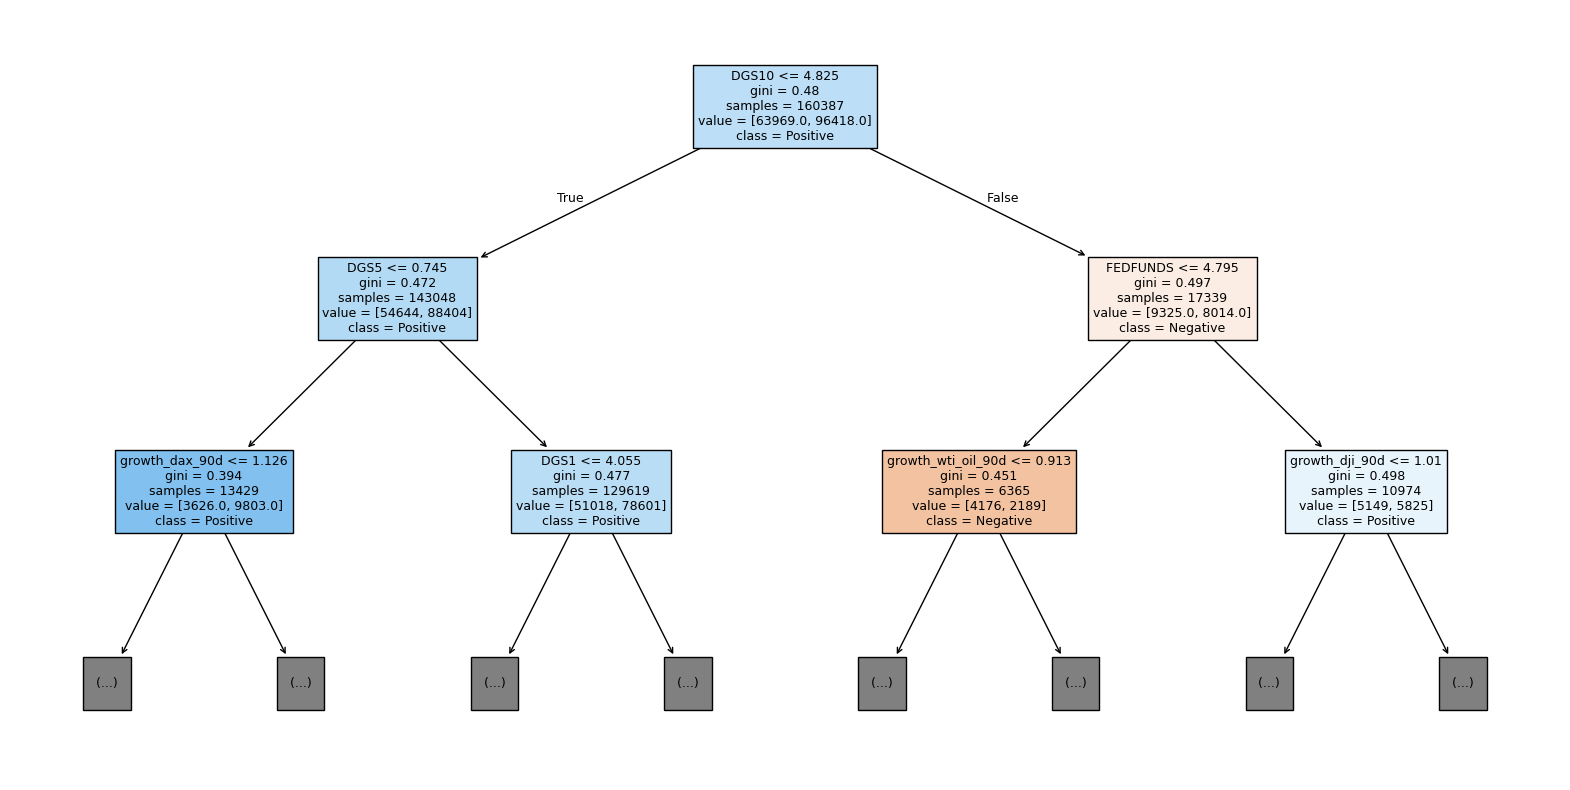

In [54]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is your trained DecisionTreeClassifier
plt.figure(figsize=(20,10))  # Set the size of the figure
plot_tree(clf_10,
          filled=True,
          feature_names=train_columns,
          class_names=['Negative', 'Positive'],
          max_depth=2)
plt.show()

In [55]:
# Feautures importance function to predict future returns (based on the classifier)
# get feature importance from 'clf' (classifier) and 'train_columns' (column names)

def get_importances(clf, train_columns):
  # Assuming clf is your trained DecisionTreeClassifier
  feature_importance = clf.feature_importances_

  # Assuming X_train is your training features
  feature_names = train_columns

  # Create a DataFrame to store feature importance
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

  # Sort the DataFrame by importance in descending order
  feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

  # Print or display the feature importance DataFrame
  # print(feature_importance_df)
  return feature_importance_df

In [56]:
get_importances(clf_10, train_columns).head(10)

,Feature,Importance
183,DGS10,0.074156
181,DGS1,0.055457
178,cpi_core_yoy,0.042166
35,growth_gold_365d,0.035608
93,ad,0.033516
41,growth_wti_oil_365d,0.030771
16,growth_snp500_90d,0.030768
95,obv,0.028995
179,cpi_core_mom,0.028526
47,growth_brent_oil_365d,0.027431


In [57]:
import numpy as np

X_all = new_df[features_list].copy()

# Replace infinite values with NaN
X_all.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs with zeros (or another strategy if you prefer)
X_all.fillna(0, inplace=True)

# Now predict safely
new_df['pred5_clf_10'] = clf_10.predict(X_all)

new_df.head()


,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_5,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,pred5_clf_10
3490,35.975752,36.358881,34.328300,35.726719,53228400.0,0.0,0.0,MSFT,2000,January,...,1,1,0,0,1,0,0,1,1,0
3491,34.807221,35.899137,34.404936,34.519875,54119000.0,0.0,0.0,MSFT,2000,January,...,1,0,0,0,1,0,1,1,1,0
3492,34.060124,35.669264,33.523744,34.883850,64059600.0,0.0,0.0,MSFT,2000,January,...,1,0,0,0,1,0,1,1,1,0
3493,34.385780,34.903004,33.217238,33.715305,54976600.0,0.0,0.0,MSFT,2000,January,...,1,0,0,0,1,0,1,1,1,0
3494,33.293845,34.404917,32.891561,34.155884,62013600.0,0.0,0.0,MSFT,2000,January,...,1,1,0,0,1,0,0,1,1,0


In [59]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS



['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_5',
 'pred5_clf_10']

In [60]:
# generate columns is_correct_
for pred in PREDICTIONS:
  part1 = pred.split('_')[0] # first prefix before '_'
  new_df[f'is_correct_{part1}'] =  (new_df[pred] == new_df.is_positive_growth_30d_future).astype(int)

In [61]:
new_df

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_5,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,pred5_clf_10,is_correct_pred5
3490,35.975752,36.358881,34.328300,35.726719,53228400.0,0.0,0.0,MSFT,2000,January,...,1,0,0,1,0,0,1,1,0,1
3491,34.807221,35.899137,34.404936,34.519875,54119000.0,0.0,0.0,MSFT,2000,January,...,0,0,0,1,0,1,1,1,0,1
3492,34.060124,35.669264,33.523744,34.883850,64059600.0,0.0,0.0,MSFT,2000,January,...,0,0,0,1,0,1,1,1,0,1
3493,34.385780,34.903004,33.217238,33.715305,54976600.0,0.0,0.0,MSFT,2000,January,...,0,0,0,1,0,1,1,1,0,1
3494,33.293845,34.404917,32.891561,34.155884,62013600.0,0.0,0.0,MSFT,2000,January,...,1,0,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5696,3664.000000,3708.899902,3662.199951,3678.899902,898170.0,0.0,0.0,LT.NS,2025,June,...,1,0,1,1,0,0,1,0,0,1
5697,3704.000000,3704.000000,3667.199951,3679.800049,1454535.0,0.0,0.0,LT.NS,2025,June,...,1,0,1,1,0,0,1,0,1,0
5698,3689.899902,3692.000000,3656.100098,3684.800049,1265737.0,0.0,0.0,LT.NS,2025,June,...,1,0,1,1,0,0,1,0,1,0
5699,3684.800049,3708.000000,3585.000000,3603.899902,2335718.0,0.0,0.0,LT.NS,2025,June,...,1,0,1,1,0,0,1,0,1,0


In [62]:
# Generate list of is_correct_ column names
IS_CORRECT = [f'is_correct_{pred.split("_")[0]}' for pred in PREDICTIONS]

# Identify the last is_correct column (for pred5_clf_10)
pred5_correct_col = IS_CORRECT[-1]

# All other is_correct columns (hand rules)
hand_rule_correct_cols = IS_CORRECT[:-1]

# Create the boolean column for unique correctness
new_df['only_pred5_is_correct'] = (
    (new_df[pred5_correct_col] == 1) &                      # pred5 correct
    (new_df[hand_rule_correct_cols].sum(axis=1) == 0)       # all others incorrect
)

# Optional: check how many rows satisfy this
print(new_df['only_pred5_is_correct'].value_counts())


only_pred5_is_correct
False    165079
True      26716
Name: count, dtype: int64


In [63]:
# Convert boolean column to integer (True -> 1, False -> 0)
new_df['only_pred5_is_correct_int'] = new_df['only_pred5_is_correct'].astype(int)

# Filter for test set records
test_df = new_df[new_df['split'] == 'test']

# Count how many records in test set have only_pred5_is_correct == 1
unique_correct_count = test_df['only_pred5_is_correct_int'].sum()

print(f"Number of unique correct predictions by pred5 on TEST set: {unique_correct_count}")


Number of unique correct predictions by pred5 on TEST set: 3832
